# Learning from Misclassification

![](https://c1.staticflickr.com/5/4340/37157583241_7cc603070c_z_d.jpg)

Tuning a classifier for maximum sensitivity or specificity can be achieved in (at least) two main steps. 
- The first is using `GridSearchCV` to fine tune your model and keep the **classifier with the highest recall score**.
- The second step is to **adjust the decision threshold** using the precision recall curve and the roc curve.

- Example of Receiver Operating Characteristic (ROC) metric to evaluate classifier output quality.

- ROC curves typically feature true positive rate on the Y axis, and false positive rate on the X axis. This means that the top left corner of the plot is the “ideal” point - a false positive rate of zero, and a true positive rate of one. This is not very realistic, but it does mean that a larger area under the curve (AUC) is usually better.

- The “steepness” of ROC curves is also important, since it is ideal to maximize the true positive rate while minimizing the false positive rate.

In [1]:
# importing necessary libraries
import numpy as np
import pandas as pd
import learning as learn # .py file that defines the functions being used

from sklearn.preprocessing import LabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix

import matplotlib.pyplot as plt
plt.style.use("ggplot")

df = pd.read_csv('../../datasets/eeg.csv')

In [2]:
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,Class
0,4329.23,4009.23,4289.23,4148.21,4350.26,4586.15,4096.92,4641.03,4222.05,4238.46,4211.28,4280.51,4635.90,4393.85,1
1,4324.62,4004.62,4293.85,4148.72,4342.05,4586.67,4097.44,4638.97,4210.77,4226.67,4207.69,4279.49,4632.82,4384.10,1
2,4327.69,4006.67,4295.38,4156.41,4336.92,4583.59,4096.92,4630.26,4207.69,4222.05,4206.67,4282.05,4628.72,4389.23,1
3,4328.72,4011.79,4296.41,4155.90,4343.59,4582.56,4097.44,4630.77,4217.44,4235.38,4210.77,4287.69,4632.31,4396.41,1
4,4326.15,4011.79,4292.31,4151.28,4347.69,4586.67,4095.90,4627.69,4210.77,4244.10,4212.82,4288.21,4632.82,4398.46,1


**Important Note: No pre-processing is being performed as the aim of this notebook is to explain how we can learn from the misclassifications that our model has aleardy predicted.**

In [3]:
# EEG eye state measurements distribution
# Class: 0, 1
df['Class'].value_counts()

1    8254
2    6722
Name: Class, dtype: int64

In [4]:
# by default majority class (benign) will be negative
lb = LabelBinarizer()
df['Class'] = lb.fit_transform(df['Class'].values)
targets = df['Class']

df.drop(['Class'], axis=1, inplace=True)

In [5]:
# data split
X_train, X_test, y_train, y_test = train_test_split(df, targets, stratify=targets)

`train_test_split` with `stratify=True` results in consistent class distribution betwen training and test sets.

In [6]:
print('y_train class distribution')
print(y_train.value_counts(normalize=True))

print('y_test class distribution')
print(y_test.value_counts(normalize=True))

y_train class distribution
0    0.551193
1    0.448807
Name: Class, dtype: float64
y_test class distribution
0    0.551015
1    0.448985
Name: Class, dtype: float64


## First strategy: Optimize for sensitivity using GridSearchCV and scoring.

First build a generic classifier and setup a parameter grid; random forests have many tunable parameters, which make it suitable for `GridSearchCV`.

The function below uses  [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) to fit several classifiers according to the combinations of parameters in the `param_grid`.  The scores from `scorers` are recorded and the best model (as scored by the `refit` argument) will be selected and "refit" to the full training data for downstream use.  This also makes predictions on the held out `X_test` and prints the confusion matrix to show performance.

The point of the wrapper function is to quickly reuse the code to fit the best classifier according to the type of scoring metric chosen. First, try `precision_score`, which should limit the number of false positives. This isn't well-suited for the goal of maxium sensitivity, but allows us to quickly show the difference between a classifier optimized for `precision_score` and one optimized for `recall_score`.

In [7]:
grid_search_clf = learn.grid_search_wrapper('precision_score', X_train, y_train, X_test, y_test)

Best params for precision_score
{'max_depth': 10, 'max_features': 5, 'min_samples_split': 5, 'n_estimators': 300}

Confusion matrix of Random Forest optimized for precision_score on the test data:
     pred_neg  pred_pos
neg      1909       154
pos       330      1351


The precision, recall, and accuracy scores for every combination of the parameters in `param_grid` are stored in `cv_results_`.  Here, a pandas DataFrame helps visualize the scores  and parameters for each classifier iteration. This is included to show that although accuracy may be relatively consistent across classifiers, it's obvious that precision and recall have a trade-off. Sorting by precision, the best scoring model should be the first record. This can be checked by looking at the parameters of the first record and comparing them to `grid_search.best_params_` above.

In [8]:
results = pd.DataFrame(grid_search_clf.cv_results_)
results = results.sort_values(by='mean_test_precision_score', ascending=False)
results[['mean_test_precision_score', 'mean_test_recall_score', 'mean_test_accuracy_score',
         'param_max_depth', 'param_max_features', 'param_min_samples_split',
         'param_n_estimators']].head()

,mean_test_precision_score,mean_test_recall_score,mean_test_accuracy_score,param_max_depth,param_max_features,param_min_samples_split,param_n_estimators
75,0.901551,0.803012,0.872237,10,5,5,300
74,0.900501,0.798646,0.870012,10,5,5,100
65,0.899982,0.779599,0.862177,10,3,3,300
77,0.899499,0.800827,0.870456,10,5,7,300
81,0.899082,0.816896,0.876688,10,10,3,300


That classifier was optimized for precision. For comparison, to show how `GridSearchCV` selects the best classifier, the function call below returns a classifier optimized for recall. The grid might be similar to the grid above, the only difference is that the classifer with the highest recall will be refit. This will be the most desirable metric in predicting whether a subject’s eyes are open or closed based only on their brain wave data (EEG) problem, there should be less false negatives on the test set confusion matrix.

In [9]:
grid_search_clf = learn.grid_search_wrapper('recall_score', X_train, y_train, X_test, y_test)

Best params for recall_score
{'max_depth': 10, 'max_features': 10, 'min_samples_split': 5, 'n_estimators': 300}

Confusion matrix of Random Forest optimized for recall_score on the test data:
     pred_neg  pred_pos
neg      1909       154
pos       314      1367


In [10]:
results = pd.DataFrame(grid_search_clf.cv_results_)
results = results.sort_values(by='mean_test_recall_score', ascending=False)
results[['mean_test_precision_score', 'mean_test_recall_score', 'mean_test_accuracy_score',
         'param_max_depth', 'param_max_features', 'param_min_samples_split',
         'param_n_estimators']].head()

,mean_test_precision_score,mean_test_recall_score,mean_test_accuracy_score,param_max_depth,param_max_features,param_min_samples_split,param_n_estimators
83,0.899111,0.818086,0.877133,10,10,5,300
81,0.898426,0.817491,0.876599,10,10,3,300
80,0.900237,0.817094,0.877311,10,10,3,100
85,0.898855,0.815706,0.876065,10,10,7,300
88,0.895843,0.814319,0.874196,10,13,3,100


The first strategy doesn't yield impressive results for `recall_score`, it doesn't significantly reduce (if at all) the number of false negatives compared to the classifier optimized for `precision_score`. Ideally, when designing a cancer diagnosis test, the classifier should strive for the fewest false negatives as possible.

## Strategy 2: Adjust the decision threshold -- Identify the operating point

The `precisoin_recall_curve` and `roc curve` are useful tools to visualize the sensitivity-specificty tradeoff in the classifier. They can help inform a data scientist where to set the decision threshold of the model to maximize either sensitivity or specificity. This is called the "operating point" of the model.

An important point to make this method generalizable to all classifiers in scikit-learn is to understand that some classifiers (like RandomForest) use `.predict_proba()` while others (like SVC) use `.decision_function()`. The idea is to get the "probability" that a sample is predicted to be in a class, not just the class returned from `.predict()`. The default threshold for `RandomForestClassifier` is 0.5

In [11]:
# this gives the probability [0,1] that each sample belongs to class 1
y_scores = grid_search_clf.predict_proba(X_test)[:, 1]

# for classifiers with decision_function, this achieves similar results
# y_scores = classifier.decision_function(X_test)

In [12]:
# generate the precision recall curve
p, r, thresholds = precision_recall_curve(y_test, y_scores)

Re-execute the next cell to tune the threshold until there are 0 False Negatives.

     pred_neg  pred_pos
neg       912      1151
pos        14      1667


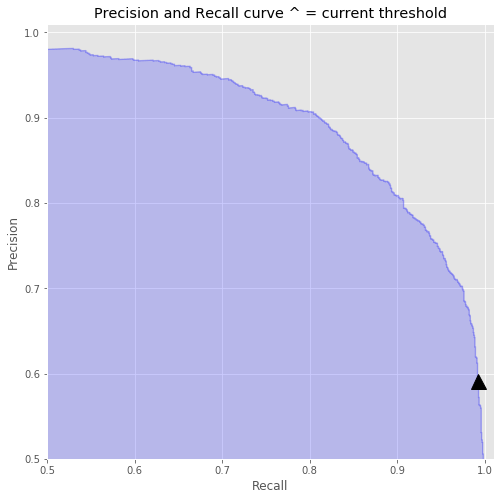

In [18]:
# The best I could do with 14 FN was 0.17, but re-execute to watch the confusion matrix change.
learn.precision_recall_threshold(0.17, y_scores, y_test, thresholds, p, r)

Another way to view the tradeoff between precision and recall is to plot them together as a function of the decision threshold.

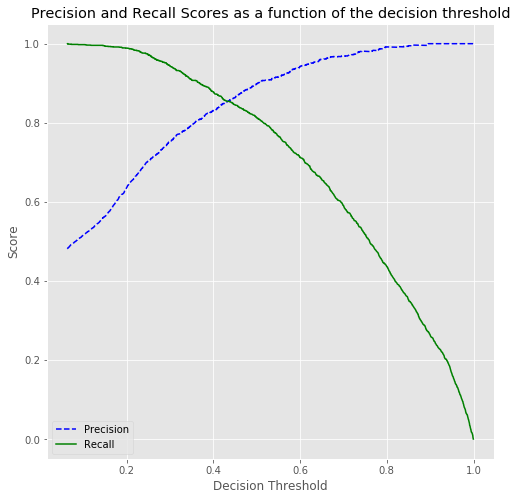

In [15]:
# use the same p, r, thresholds that were previously calculated
learn.plot_precision_recall_vs_threshold(p, r, thresholds)

Finally, the ROC curve shows that to achieve a 1.0 recall, we must accept some false positive rate > 0.0.

0.9481594496731888


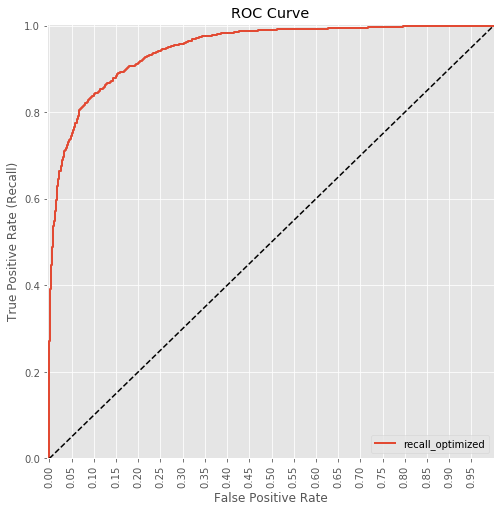

In [16]:
fpr, tpr, auc_thresholds = roc_curve(y_test, y_scores)
print(auc(fpr, tpr)) # AUC of ROC
learn.plot_roc_curve(fpr, tpr, 'recall_optimized')